In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color=sns.color_palette()#画图用的颜色啥的格子等等
sns.set_style('darkgrid')#


import warnings#
def ignore_warn(*args,**kwargs):
 pass
warnings.warn=ignore_warn#用来忽略warning提示用的
#import warnings或者这样用
#warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm,skew#

pd.set_option('display.float_format',lambda x: '{:.3f}'.format(x))#限制浮点数的输出
from subprocess import check_output
#print(check_output(["ls", "../Housing"]).decode("utf8")) #检查问价你的输出


In [137]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.head()

print(train.columns.size)#列数 
print(train.iloc[:,0].size)#行数 
print(test.columns.size)#列数 
print(test.iloc[:,0].size)#行数 

81
1460
80
1459


In [138]:
train_Id=train['Id']
test_Id=test['Id']

train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


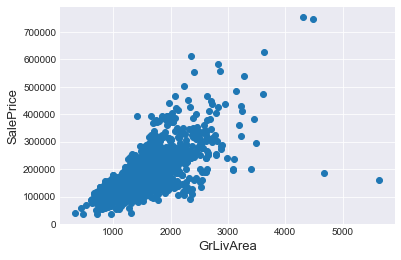

In [139]:
fig,ax=plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

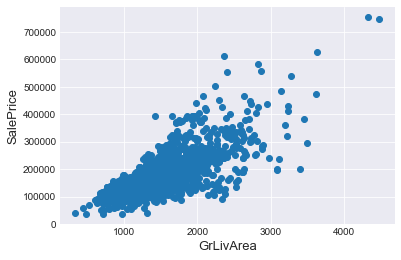

In [140]:
#将比较离散不符合实际的点删掉，那条记录都删掉
train=train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index)
fig,ax=plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()


 mu=180932.92 and sigma=79467.79



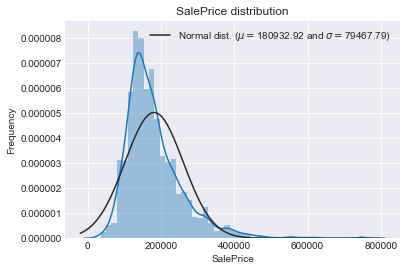

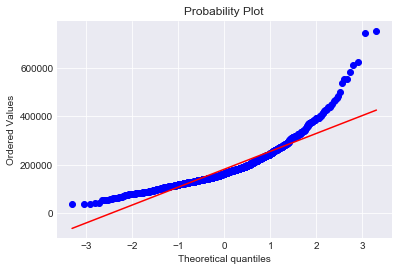

In [141]:

sns.distplot(train['SalePrice'],fit=norm);
(mu,sigma)=norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#线性的模型需要正态分布的目标值才能发挥最大的作用。
#我们需要检测房价时候偏离正态分布。使用probplot函数，即正太概率图
fig=plt.figure()
res=stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



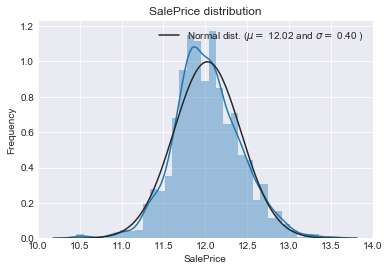

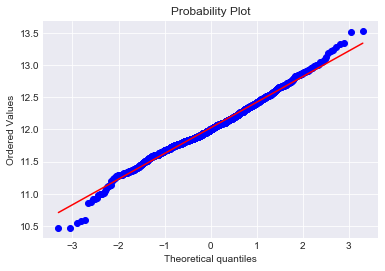

In [142]:
#图1中黑线是是正太，此时正态分布明显属于右态分布，
#整体峰值向左偏离，需要对目标值做log转换，以恢复目标值的正态性。

train['SalePrice']=np.log(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm);
#mu,sigma指的是fit后的参数
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#下面同上画图标

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [143]:
#all_data=pd.concat([train,test],join='inner')
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
print(all_data.columns.size)#列数 
print(all_data.iloc[:,0].size)#行数 
print(train.columns.size)#列数 
print(train.iloc[:,0].size)#行数 
print(test.columns.size)#列数 
print(test.iloc[:,0].size)#行数 


total = all_data.isnull().sum().sort_values(ascending=False)
mm=all_data.isnull().count().sort_values(ascending=False)

percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent,mm], axis=1, keys=['Total', 'Percent','mm'])
missing_data.head()

all_data size is : (2917, 79)
79
2917
80
1458
79
1459


,Total,Percent,mm
1stFlrSF,0,0.000,2917
2ndFlrSF,0,0.000,2917
3SsnPorch,0,0.000,2917
Alley,2719,0.932,2917
BedroomAbvGr,0,0.000,2917


In [144]:
#缺失率的值，为0的缺失率删除
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680


Text(0.5,1,'Percent missing data by feature')

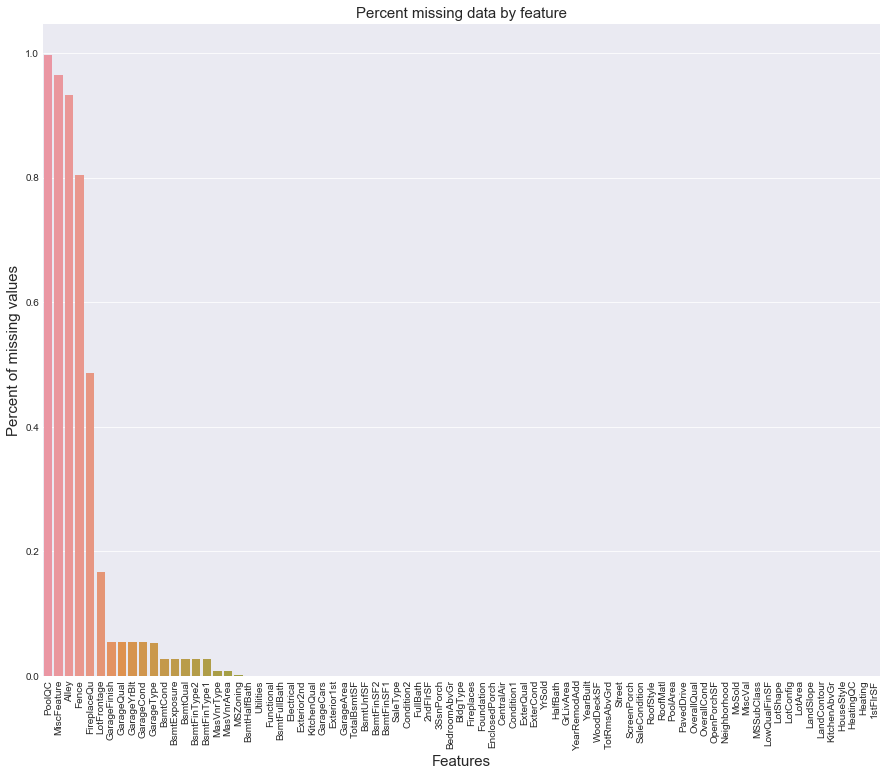

In [145]:
f,ax=plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=total.index,y=percent)
plt.xlabel('Features',fontsize=15)
plt.ylabel('Percent of missing values',fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)



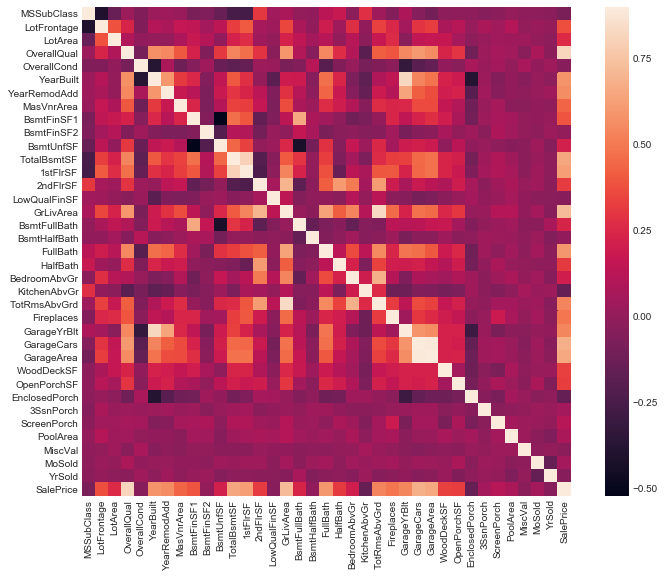

In [146]:
corrmat=train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)


In [147]:
#观察上图中有一些直接是正相关的特征，GarageAreas和GarageCars，TotaLBsmtSF和1stFlrSF
#缺失值的填补就有了依据
#下面都是补全缺失值
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))#填补中位数
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):#补0
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])#缺失值用众数
all_data = all_data.drop(['Utilities'], axis=1)#值基本上都一样，直接drop
all_data["Functional"] = all_data["Functional"].fillna("Typ")#用最多的
#用众数
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")




In [148]:
#将一些是数字的转化为字符串类别，比如说房屋类别MSSubClass
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

all_data['OverallCond']=all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)

all_data['MoSold'] = all_data['MoSold'].astype(str)

In [149]:
#好像是对对文本类别的特征进行编号，使用LabelEncoder
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [150]:
# 算出房屋总面积,这个特征是自行添加的
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [151]:
#对房价进行分析，找出所有的数字的特征，进行偏度分析，之后要多这些进行转化
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


In [152]:
#找出哪些偏度值大于0.75的特征
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [189]:
all_data = pd.get_dummies(all_data)#哑变量就是对一些字符类型的转变为0-1编码的感觉
train = all_data[:ntrain]
test = all_data[ntrain:]

In [166]:
#模型的选择
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
import xgboost as xgb
#import lightgbm as lgb

In [156]:
#使用Sklearn的cross_val_score函数。然而这个函数没有shuffle方法，添加了一行代码，为了在交叉验证之前shuffle数据集。
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [157]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# Elastic Net Regression :
# again made robust to outliers

In [158]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# Kernel Ridge Regression :

In [159]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# Gradient Boosting Regression :
# With huber loss that makes it robust to outliers

In [160]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


In [161]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


In [167]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [168]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1114 (0.0074)



下面这个是平均模型融合的例子：得分情况

In [178]:
#模型融合
#Stacking模型融合：
#Average-Stackin 最简单的平均基本模型的Stacking方法开始模型融合。
#建立一个新的类来扩展scikit模型融合方法：用四个来进行平均融合

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [179]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Averaged base models score: 0.1085 (0.0076)



Meta-model Stacking：

算法：

1、将整个训练集分解成两个不相交的集合（这里是train和.holdout）。 
2、在第一部分（train）上训练几个基本模型。 
3、在第二个部分（holdout）上测试这些基本模型。 
4、使用(3)中的预测（称为 out-of-fold 预测）作为输入，并将正确的标签（目标变量）作为输出来训练更高层次的学习模型称为元模型。

前三个步骤是迭代完成的。例如，如果我们采取5倍的fold，我们首先将训练数据分成5次。然后我们会做5次迭代。在每次迭代中，我们训练每个基础模型4倍，并预测剩余的fold（holdout fold）。


In [190]:
#BaseEstimator： 估计器的基类，RegressorMixin ：回归器的混合类，TransformerMixin ：转换器的混合类
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models#基本模型
        self.meta_model = meta_model#元模型
        self.n_folds = n_folds#n指代样本数，n_folds指代将数据集分成多少份且做几次验证试验。 
#在初始化对象k_fold里已经包含了许多信息，它已经根据参数n和n_folds将n个样本分成n_folds份。每次验证过程选取其中1份作为测试集，剩下的n_folds-1份作为训练集，并且做n_folds次这样的验证。



    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        print(self.base_models)
        self.meta_model_ = clone(self.meta_model)#验证元模型
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)#k折验证

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))#
        for i, model in enumerate(self.base_models):#
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [191]:
#使用来三个来进行元模型融合
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))]), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False), KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None))
(Pipeline(memory=None,
     step

In [183]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [185]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print("StackedRegressor: ",rmsle(y_train, stacked_train_pred))

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print("XGBoost: ",rmsle(y_train, xgb_train_pred))

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.30  ))


StackedRegressor:  0.07919248506967753
XGBoost:  0.07907433513239767
RMSLE score on train data:
0.07705118524597937


In [187]:
ensemble = stacked_pred*0.70 + xgb_pred*0.30

sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)